In [1]:
!pip install pyspark==3.1.2 contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212.4 MB 45 kB/s 
     |████████████████████████████████| 198 kB 48.8 MB/s 
     |████████████████████████████████| 287 kB 52.7 MB/s 
     |████████████████████████████████| 110 kB 43.8 MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.2-py2.py3-none-any.whl size=212880769 sha256=c741816e0bfb1fcc4639efb6bdcf3ef35f4958012a82f14759524a4d560babb3
  Stored in directory: /root/.cache/pip/wheels/df/88/9e/58ef1f74892fef590330ca0830b5b6d995ba29b44f977b3926
Successfully built pyspark


In [ ]:

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import SparkSession ,Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

import json
from glob import glob



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

#project_folder = '/content/drive/Shareddrives/small_review/'
project_folder = '/content/drive/MyDrive/Fall2022/CS777/'
os.chdir(project_folder)
# !unzip /content/drive/MyDrive/Fall2022/CS777/yelp_academic_dataset_review.json.zip

In [ ]:
# Pyspark
appName="Collaborative Filtering with PySpark"

#initialize the spark session
spark = SparkSession.builder.appName(appName).getOrCreate()

#get sparkcontext from the sparksession
sc = spark.sparkContext
sqlContext = SQLContext(sc)

review_path = project_folder + 'yelp_academic_dataset_review.json'

df_review = sqlContext.read.json(review_path)

df_review_small = df_review.sample(0.01)

In [ ]:
path = project_folder + 'yelp_academic_dataset_review.json'

chunks = [] 
dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32} 
path = project_folder + 'yelp_academic_dataset_review.json'
reader = pd.read_json(path,
                      lines=True,
                      chunksize=1000,
                      dtype=dtypes,
                      orient='records')

for chunk in reader:
        reduced_chunks = chunk.drop(columns=['review_id', 'user_id'])
        chunks.append(reduced_chunks)
    
total_reviews = pd.concat(chunks, ignore_index=True)

In [ ]:
large_reviews = total_reviews.sample(frac = 0.95)
reviews_small = total_reviews.drop(large_reviews.index)

Text(0, 0.5, 'Total reviews count')

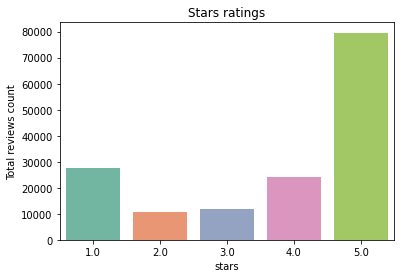

In [ ]:
plot = sns.countplot(x='stars', data=reviews_small, palette="Set2")
plot.set_title('Stars ratings')
plot.set_ylabel('Total reviews count')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of text length')

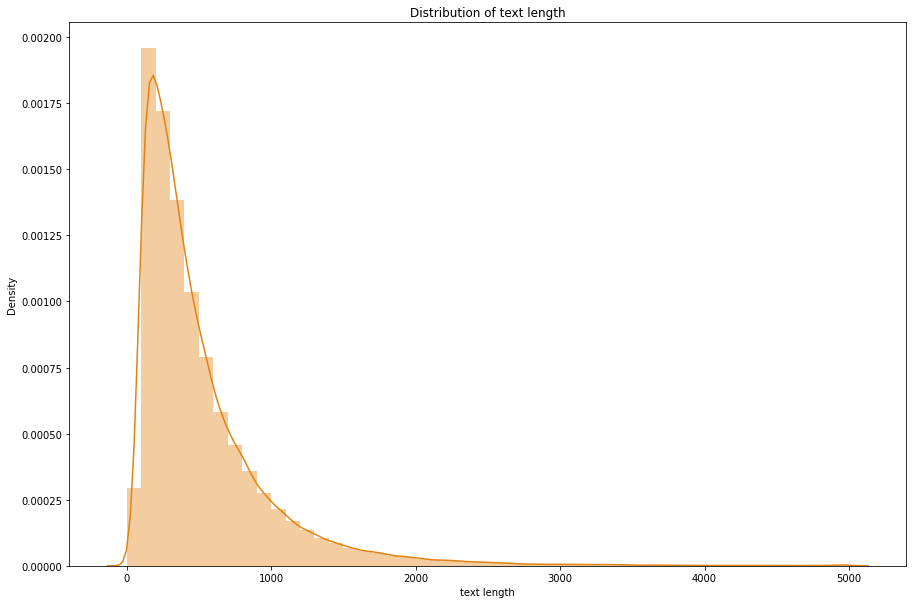

In [ ]:
#reviews = reviews_small.drop(['date','business_id','review_id','user_id'], axis =1)
reviews_small['text length'] = reviews_small['text'].apply(len)

fig = plt.figure(figsize=(15,10))
sns.distplot(reviews_small['text length'], kde=True, bins=50, color='#e28211')
plt.title('Distribution of text length')


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string
import contractions
import spacy
nlp = spacy.load('en_core_web_sm')

text_review = reviews_small[['stars','text']]
cached_SW = stopwords.words("english")

def preprocessing(text):
    punctuation = [word for word in tokens if word not in string.punctuation]
    punctuation = ''.join(punctuation)
    return [word for word in punctuation if word not in cached_SW]
text_cleaned = text_review.copy()
text_cleaned['text'] = text_review['text'].apply(preprocessing)
text_cleaned.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


ModuleNotFoundError: ignored

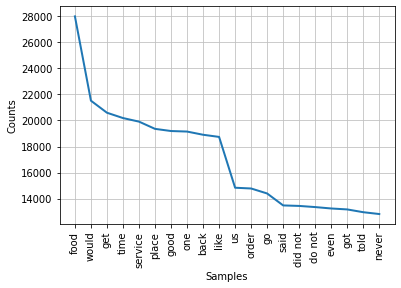

In [ ]:
from wordcloud import WordCloud, STOPWORDS
def Freq_plot(data):
    FreqDist(np.concatenate(data.text.reset_index(drop=True))).plot(20, cumulative=False)
Freq_plot(text_cleaned[text_cleaned['stars'].isin([1,2,3])])


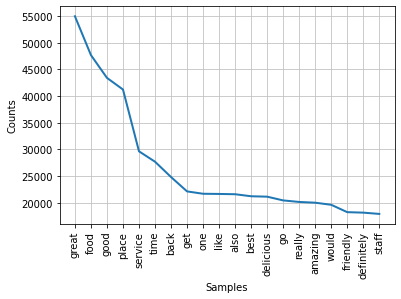

In [ ]:
Freq_plot(text_cleaned[text_cleaned['stars'].isin([4,5])])


In [ ]:
def text_reviewCloud(star):
    text = ' '.join(text_review[text_review['stars'].isin(star)]['text'])
    wordcloud = WordCloud(
      width = 2000,
      height = 1500,
      background_color = 'white',
      stopwords = STOPWORDS).generate(str(text))

    fig = plt.figure(
        figsize = (9, 6) )
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

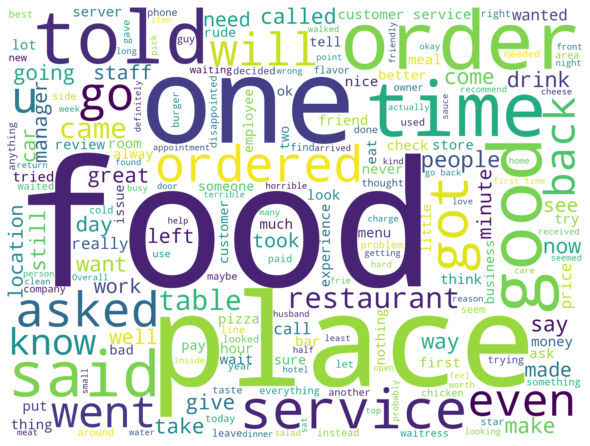

In [ ]:
text_reviewCloud([1,2,3])

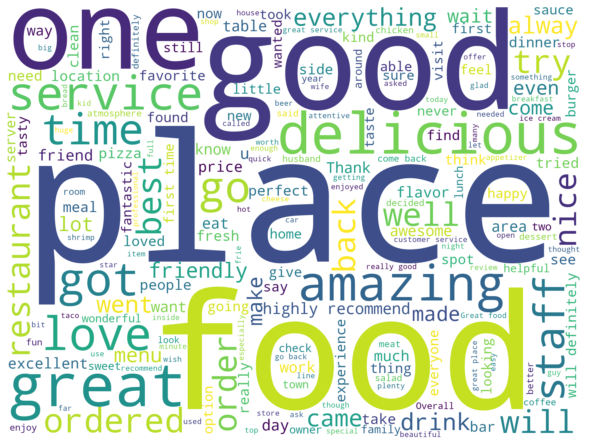

In [ ]:
text_reviewCloud([4,5])